## Setup autoreload, warnings and helper functions

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

## Set the visibility of cuda devices (in case your system contains more than one)

In [5]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Imports

In [31]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import COCOImageDataset, DatasetSlice, SequenceDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step, read_image
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single, encode_sequence_dataset
from reidentification.visualisation import visualise_match
from simple_database import SimpleDatabase

## Create a configuration file.
You can change the default parameters in config.py

In [7]:
cfg = config()


/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
2022-11-11 13:38:15.497686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-11 13:38:15.498431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-11-11 13:38:15.499100: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-11 13:3

## Download the dataset

In [9]:
cfg["dataset_dir"] = "/ekaterina/work/data/many_dataset/pattern"
dataset_dir = Path(cfg["dataset_dir"])

if not dataset_dir.exists():
    
    print("Download and extract dataset")
    # Get a single use download link from https://etsin.fairdata.fi/dataset/22b5191e-f24b-4457-93d3-95797c900fc0/data
    # You will only need "full images.zip" for the reidentification, generate a link to that.
    dataset_url = ""
    
    print(f'Creating directory "{dataset_dir}"')
    dataset_dir.mkdir(parents=True, exist_ok=True)
    
    file = wget.download(dataset_url.replace(" ", "%20"), out=str(dataset_dir))
    print()
    print(f'Extracting "{file}"')
    zip_f = zipfile.ZipFile(file, 'r')
    zip_f.extractall(dataset_dir)
    zip_f.close()
    Path(file).unlink()

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [33]:
dataset_dir = Path(cfg["dataset_dir"])

pattern_query_dataset = SequenceDataset(dataset_dir)

sequence_data = pattern_query_dataset[3]
print(sequence_data)

([<PIL.Image.Image image mode=RGB size=156x124 at 0x7F58EDA1EDD0>, <PIL.Image.Image image mode=RGB size=160x164 at 0x7F58EDA26590>, <PIL.Image.Image image mode=RGB size=160x128 at 0x7F58EDA26BD0>, <PIL.Image.Image image mode=RGB size=165x154 at 0x7F58EDA26750>, <PIL.Image.Image image mode=RGB size=164x139 at 0x7F58EDA26390>, <PIL.Image.Image image mode=RGB size=162x139 at 0x7F58EDA264D0>, <PIL.Image.Image image mode=RGB size=171x134 at 0x7F58EDA261D0>, <PIL.Image.Image image mode=RGB size=153x138 at 0x7F58EDA26D90>, <PIL.Image.Image image mode=RGB size=175x143 at 0x7F58EDA26290>, <PIL.Image.Image image mode=RGB size=171x143 at 0x7F58EDA26650>, <PIL.Image.Image image mode=RGB size=192x101 at 0x7F58EDA26A10>, <PIL.Image.Image image mode=RGB size=170x133 at 0x7F58EDA1EE10>, <PIL.Image.Image image mode=RGB size=193x147 at 0x7F58EDA98590>, <PIL.Image.Image image mode=RGB size=195x114 at 0x7F58EDA98710>, <PIL.Image.Image image mode=RGB size=133x150 at 0x7F58EDA98650>, <PIL.Image.Image image 

## Show an image from the dataset

# Input image

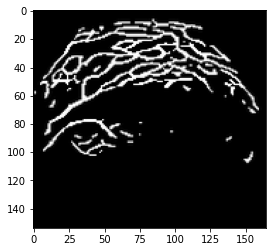

In [34]:
images, label = sequence_data

img = images[3]
print_heading("Input image")
plt.imshow(img)
plt.show()

## Apply tonemapping

## Segment and crop an image

## Extract pattern from an image

## Encode an image

In [41]:
encoded_sequence = encode_sequence_dataset([(images[:4],0)], cfg)
print("Encoded sequence")

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
Encoded sequence


## Create a small database for testing
This example uses a very simple database implemented as a Python class. The database might take a lot of space if all images are used, and in that case it is better to store it on a disc, e.g. with the help of SQL based database systems.

In [ ]:
database_dataset_mini = DatasetSlice(database_dataset, range(20))

pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step
            ]

pattern_dataset = apply_pipeline_cocodataset(database_dataset_mini, pipeline)

db_components, codebooks = create_database(pattern_dataset, cfg)

simple_db = SimpleDatabase(*db_components)
print("Created a test database")

## Perform re-identification

In [ ]:
identification_result = identify([(encoded_img, label)], database=simple_db, cfg=cfg)

## Visualise re-identification results

In [ ]:
visualise_match(identification_result[0])
print()

## Apply full pipeline to another query image

In [ ]:
full_pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step,
            curry(encode_pipeline, cfg=cfg),
            curry(identify_single, database=simple_db, cfg=cfg),
            visualise_match
            ]

apply_pipeline(*query_dataset[0], full_pipeline)
print()